### 0. Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_ta as ta
import datetime
from xgboost import XGBRegressor, plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

### 1. Read data into Dataframe

In [53]:
df = pd.read_csv('../../long_short_local/raw_data/cleaned_data.csv')

### 2. Prepare data

#### 2.1 Add SMA (simple moving average)

In [54]:
# convert 'Date' column to datetime values
df['Date'] = pd.to_datetime(df['Date'].str[:10])

In [55]:
sma_10_df_prep = pd.DataFrame(df['Date'])

for ratio in df.columns:
    test_df = df[['Date', ratio]]
    sma10 = pd.DataFrame(ta.sma(test_df[ratio], length=10))
    loop_df = pd.concat([test_df, sma10], axis=1, ignore_index=False)
    loop_df.rename(columns={'SMA_10': f'{ratio}_SMA_10'}, inplace=True)
    sma_10_df_prep = pd.concat([sma_10_df_prep, loop_df], axis=1, ignore_index=False)

In [56]:
sma_10_df = sma_10_df_prep.iloc[:, 3:]

In [57]:
sma_10_df.head()

,Date,TEL_BIO,TEL_BIO_SMA_10,Date,ADP_SYK,ADP_SYK_SMA_10,Date,ON_MU,ON_MU_SMA_10,Date,...,IT_NEM_SMA_10,Date,NRG_NEM,NRG_NEM_SMA_10,Date,SCHW_NEM,SCHW_NEM_SMA_10,Date,TT_NEM,TT_NEM_SMA_10
0,2022-02-23,0.239509,NaN,2022-02-23,0.771140,NaN,2022-02-23,0.663637,NaN,2022-02-23,...,NaN,2022-02-23,0.537846,NaN,2022-02-23,1.220489,NaN,2022-02-23,2.195844,NaN
1,2022-02-24,0.234301,NaN,2022-02-24,0.774126,NaN,2022-02-24,0.689893,NaN,2022-02-24,...,NaN,2022-02-24,0.570192,NaN,2022-02-24,1.244242,NaN,2022-02-24,2.280275,NaN
2,2022-02-25,0.223696,NaN,2022-02-25,0.766083,NaN,2022-02-25,0.707117,NaN,2022-02-25,...,NaN,2022-02-25,0.557495,NaN,2022-02-25,1.274335,NaN,2022-02-25,2.292504,NaN
3,2022-02-28,0.225564,NaN,2022-02-28,0.773484,NaN,2022-02-28,0.706936,NaN,2022-02-28,...,NaN,2022-02-28,0.569553,NaN,2022-02-28,1.287397,NaN,2022-02-28,2.339218,NaN
4,2022-03-01,0.217456,NaN,2022-03-01,0.767553,NaN,2022-03-01,0.693815,NaN,2022-03-01,...,NaN,2022-03-01,0.527591,NaN,2022-03-01,1.138470,NaN,2022-03-01,2.216707,NaN


In [58]:
sma_10_df.iloc[:, :3]

,Date,TEL_BIO,TEL_BIO_SMA_10
0,2022-02-23,0.239509,NaN
1,2022-02-24,0.234301,NaN
2,2022-02-25,0.223696,NaN
3,2022-02-28,0.225564,NaN
4,2022-03-01,0.217456,NaN
...,...,...,...
121,2022-08-17,0.258362,0.249195
122,2022-08-18,0.263737,0.250940
123,2022-08-19,0.264347,0.252804
124,2022-08-22,0.259488,0.254014


In [46]:
#sma_10_df.set_index('Date', inplace=True)

In [59]:
sma_10_df.head()

,Date,TEL_BIO,TEL_BIO_SMA_10,Date,ADP_SYK,ADP_SYK_SMA_10,Date,ON_MU,ON_MU_SMA_10,Date,...,IT_NEM_SMA_10,Date,NRG_NEM,NRG_NEM_SMA_10,Date,SCHW_NEM,SCHW_NEM_SMA_10,Date,TT_NEM,TT_NEM_SMA_10
0,2022-02-23,0.239509,NaN,2022-02-23,0.771140,NaN,2022-02-23,0.663637,NaN,2022-02-23,...,NaN,2022-02-23,0.537846,NaN,2022-02-23,1.220489,NaN,2022-02-23,2.195844,NaN
1,2022-02-24,0.234301,NaN,2022-02-24,0.774126,NaN,2022-02-24,0.689893,NaN,2022-02-24,...,NaN,2022-02-24,0.570192,NaN,2022-02-24,1.244242,NaN,2022-02-24,2.280275,NaN
2,2022-02-25,0.223696,NaN,2022-02-25,0.766083,NaN,2022-02-25,0.707117,NaN,2022-02-25,...,NaN,2022-02-25,0.557495,NaN,2022-02-25,1.274335,NaN,2022-02-25,2.292504,NaN
3,2022-02-28,0.225564,NaN,2022-02-28,0.773484,NaN,2022-02-28,0.706936,NaN,2022-02-28,...,NaN,2022-02-28,0.569553,NaN,2022-02-28,1.287397,NaN,2022-02-28,2.339218,NaN
4,2022-03-01,0.217456,NaN,2022-03-01,0.767553,NaN,2022-03-01,0.693815,NaN,2022-03-01,...,NaN,2022-03-01,0.527591,NaN,2022-03-01,1.138470,NaN,2022-03-01,2.216707,NaN


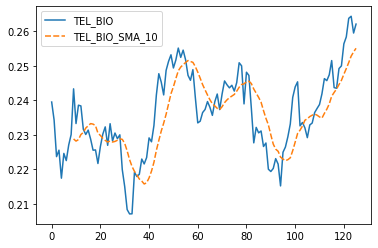

In [60]:
sns.lineplot(data=sma_10_df.iloc[:, :3]);

DO NOT CHANGE !

In [ ]:
df = pd.read_csv('../../long_short_local/raw_data/cleaned_data.csv')
# convert 'Date' column to datetime values
df['Date'] = pd.to_datetime(df['Date'].str[:10])

test_df = df[['Date', 'TEL_BIO']]
sma10 = pd.DataFrame(ta.sma(test_df["TEL_BIO"], length=10))
tel_bio_df = pd.concat([test_df, sma10], axis=1, ignore_index=False)
tel_bio_df.set_index('Date', inplace=True)
sns.lineplot(data=tel_bio_df);

DO NOT CHANGE !

In [ ]:
# convert 'Date' column to datetime values
df['Date'] = pd.to_datetime(df['Date'].str[:10])

In [ ]:
# split into 'train' and 'test' data
split_date = df['Date'][41]
df.set_index('Date', inplace=True)
train_df = df.loc[df.index <= split_date].copy()
test_df = df.loc[df.index > split_date].copy()

In [ ]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.weekofyear

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
X_train, y_train = create_features(train_df, label='number')

In [ ]:
X_test, y_test = create_features(test_df, label='number')

In [ ]:
# build first model
model = XGBRegressor(n_estimators=1000)

In [ ]:
model.fit()